In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression #, Ridge, Lasso
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression #, Ridge, Lasso
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
RSEED=826

In [3]:
df = pd.read_csv('data/data.csv')
df.shape

(30557, 82)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30557 entries, 0 to 30556
Data columns (total 82 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Place_ID X Date                                      30557 non-null  object 
 1   Date                                                 30557 non-null  object 
 2   Place_ID                                             30557 non-null  object 
 3   target                                               30557 non-null  float64
 4   target_min                                           30557 non-null  float64
 5   target_max                                           30557 non-null  float64
 6   target_variance                                      30557 non-null  float64
 7   target_count                                         30557 non-null  int64  
 8   precipitable_water_entire_atmosphere                 30557 non-nul

In [5]:
df.head()

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.000000,60.200001,...,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.600000,48.799999,...,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652
2,010Q650 X 2020-01-04,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.400000,33.400002,...,49.839714,-78.342701,34.296977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,010Q650 X 2020-01-05,2020-01-05,010Q650,49.0,10.0,55.0,1113.67,96,6.911948,21.300001,...,29.181258,-73.896588,30.545446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,010Q650 X 2020-01-06,2020-01-06,010Q650,21.0,9.0,52.0,1164.82,95,13.900001,44.700001,...,0.797294,-68.612480,26.899694,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
for col in df.columns:
    if 'angle' in col or 'amf' in col[-3:]:
        df.drop([col], axis=1, inplace=True)

drop_cols = ['L3_CH4_CH4_column_volume_mixing_ratio_dry_air', 'L3_CH4_aerosol_height', 'L3_CH4_aerosol_optical_depth']
df.drop(drop_cols, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30557 entries, 0 to 30556
Data columns (total 45 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Place_ID X Date                                  30557 non-null  object 
 1   Date                                             30557 non-null  object 
 2   Place_ID                                         30557 non-null  object 
 3   target                                           30557 non-null  float64
 4   target_min                                       30557 non-null  float64
 5   target_max                                       30557 non-null  float64
 6   target_variance                                  30557 non-null  float64
 7   target_count                                     30557 non-null  int64  
 8   precipitable_water_entire_atmosphere             30557 non-null  float64
 9   relative_humidity_2m_above_g

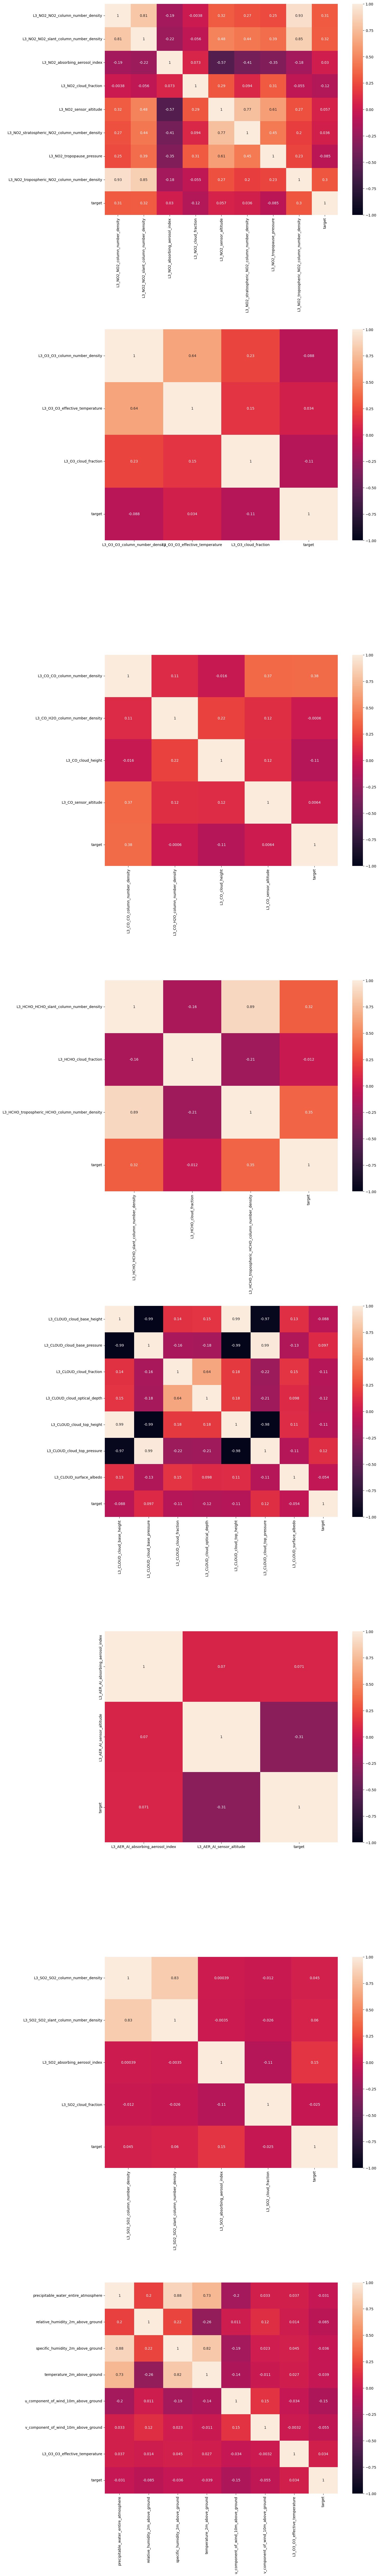

In [7]:
gases = ['NO2', 'O3', 'CO', 'HCHO', 'CLOUD', 'AER', 'SO2']

fig, axes = plt.subplots(len(gases)+1, 1, figsize=(16, 100))
axes = axes.flatten()

for ax, gas in zip(axes, gases):
    col_keeps = [col for col in df.columns if gas in col]
    corr_gas = df[col_keeps + ['target']]
    sns.heatmap(corr_gas.corr(), annot=True, ax=ax, vmin=-1, vmax=1)

weather = ['humidity', 'wind', 'water', 'temperature']

col_keeps = [col for col in df.columns for w in weather if w in col]
corr_weather = df[col_keeps + ['target']]
sns.heatmap(corr_weather.corr(), annot=True, ax=axes[-1], vmin=-1, vmax=1)

plt.tight_layout(pad = 3)

In [8]:
use = list(df.columns[8:]) + ['target']
corr_df = df[use].corr().abs()

upper_tri = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(bool))

threshold = 0.7
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
print(f'Columns to drop [{len(to_drop)}]:', to_drop)

df.drop(to_drop, axis=1, inplace=True)
df.info()

Columns to drop [18]: ['specific_humidity_2m_above_ground', 'temperature_2m_above_ground', 'L3_NO2_NO2_slant_column_number_density', 'L3_NO2_stratospheric_NO2_column_number_density', 'L3_NO2_tropospheric_NO2_column_number_density', 'L3_O3_cloud_fraction', 'L3_CO_H2O_column_number_density', 'L3_CO_sensor_altitude', 'L3_HCHO_cloud_fraction', 'L3_HCHO_tropospheric_HCHO_column_number_density', 'L3_CLOUD_cloud_base_pressure', 'L3_CLOUD_cloud_fraction', 'L3_CLOUD_cloud_top_height', 'L3_CLOUD_cloud_top_pressure', 'L3_AER_AI_absorbing_aerosol_index', 'L3_SO2_SO2_slant_column_number_density', 'L3_SO2_absorbing_aerosol_index', 'L3_SO2_cloud_fraction']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30557 entries, 0 to 30556
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Place_ID X Date                           30557 non-null  object 
 1   Date                   

In [9]:
df.duplicated().value_counts()

False    30557
Name: count, dtype: int64

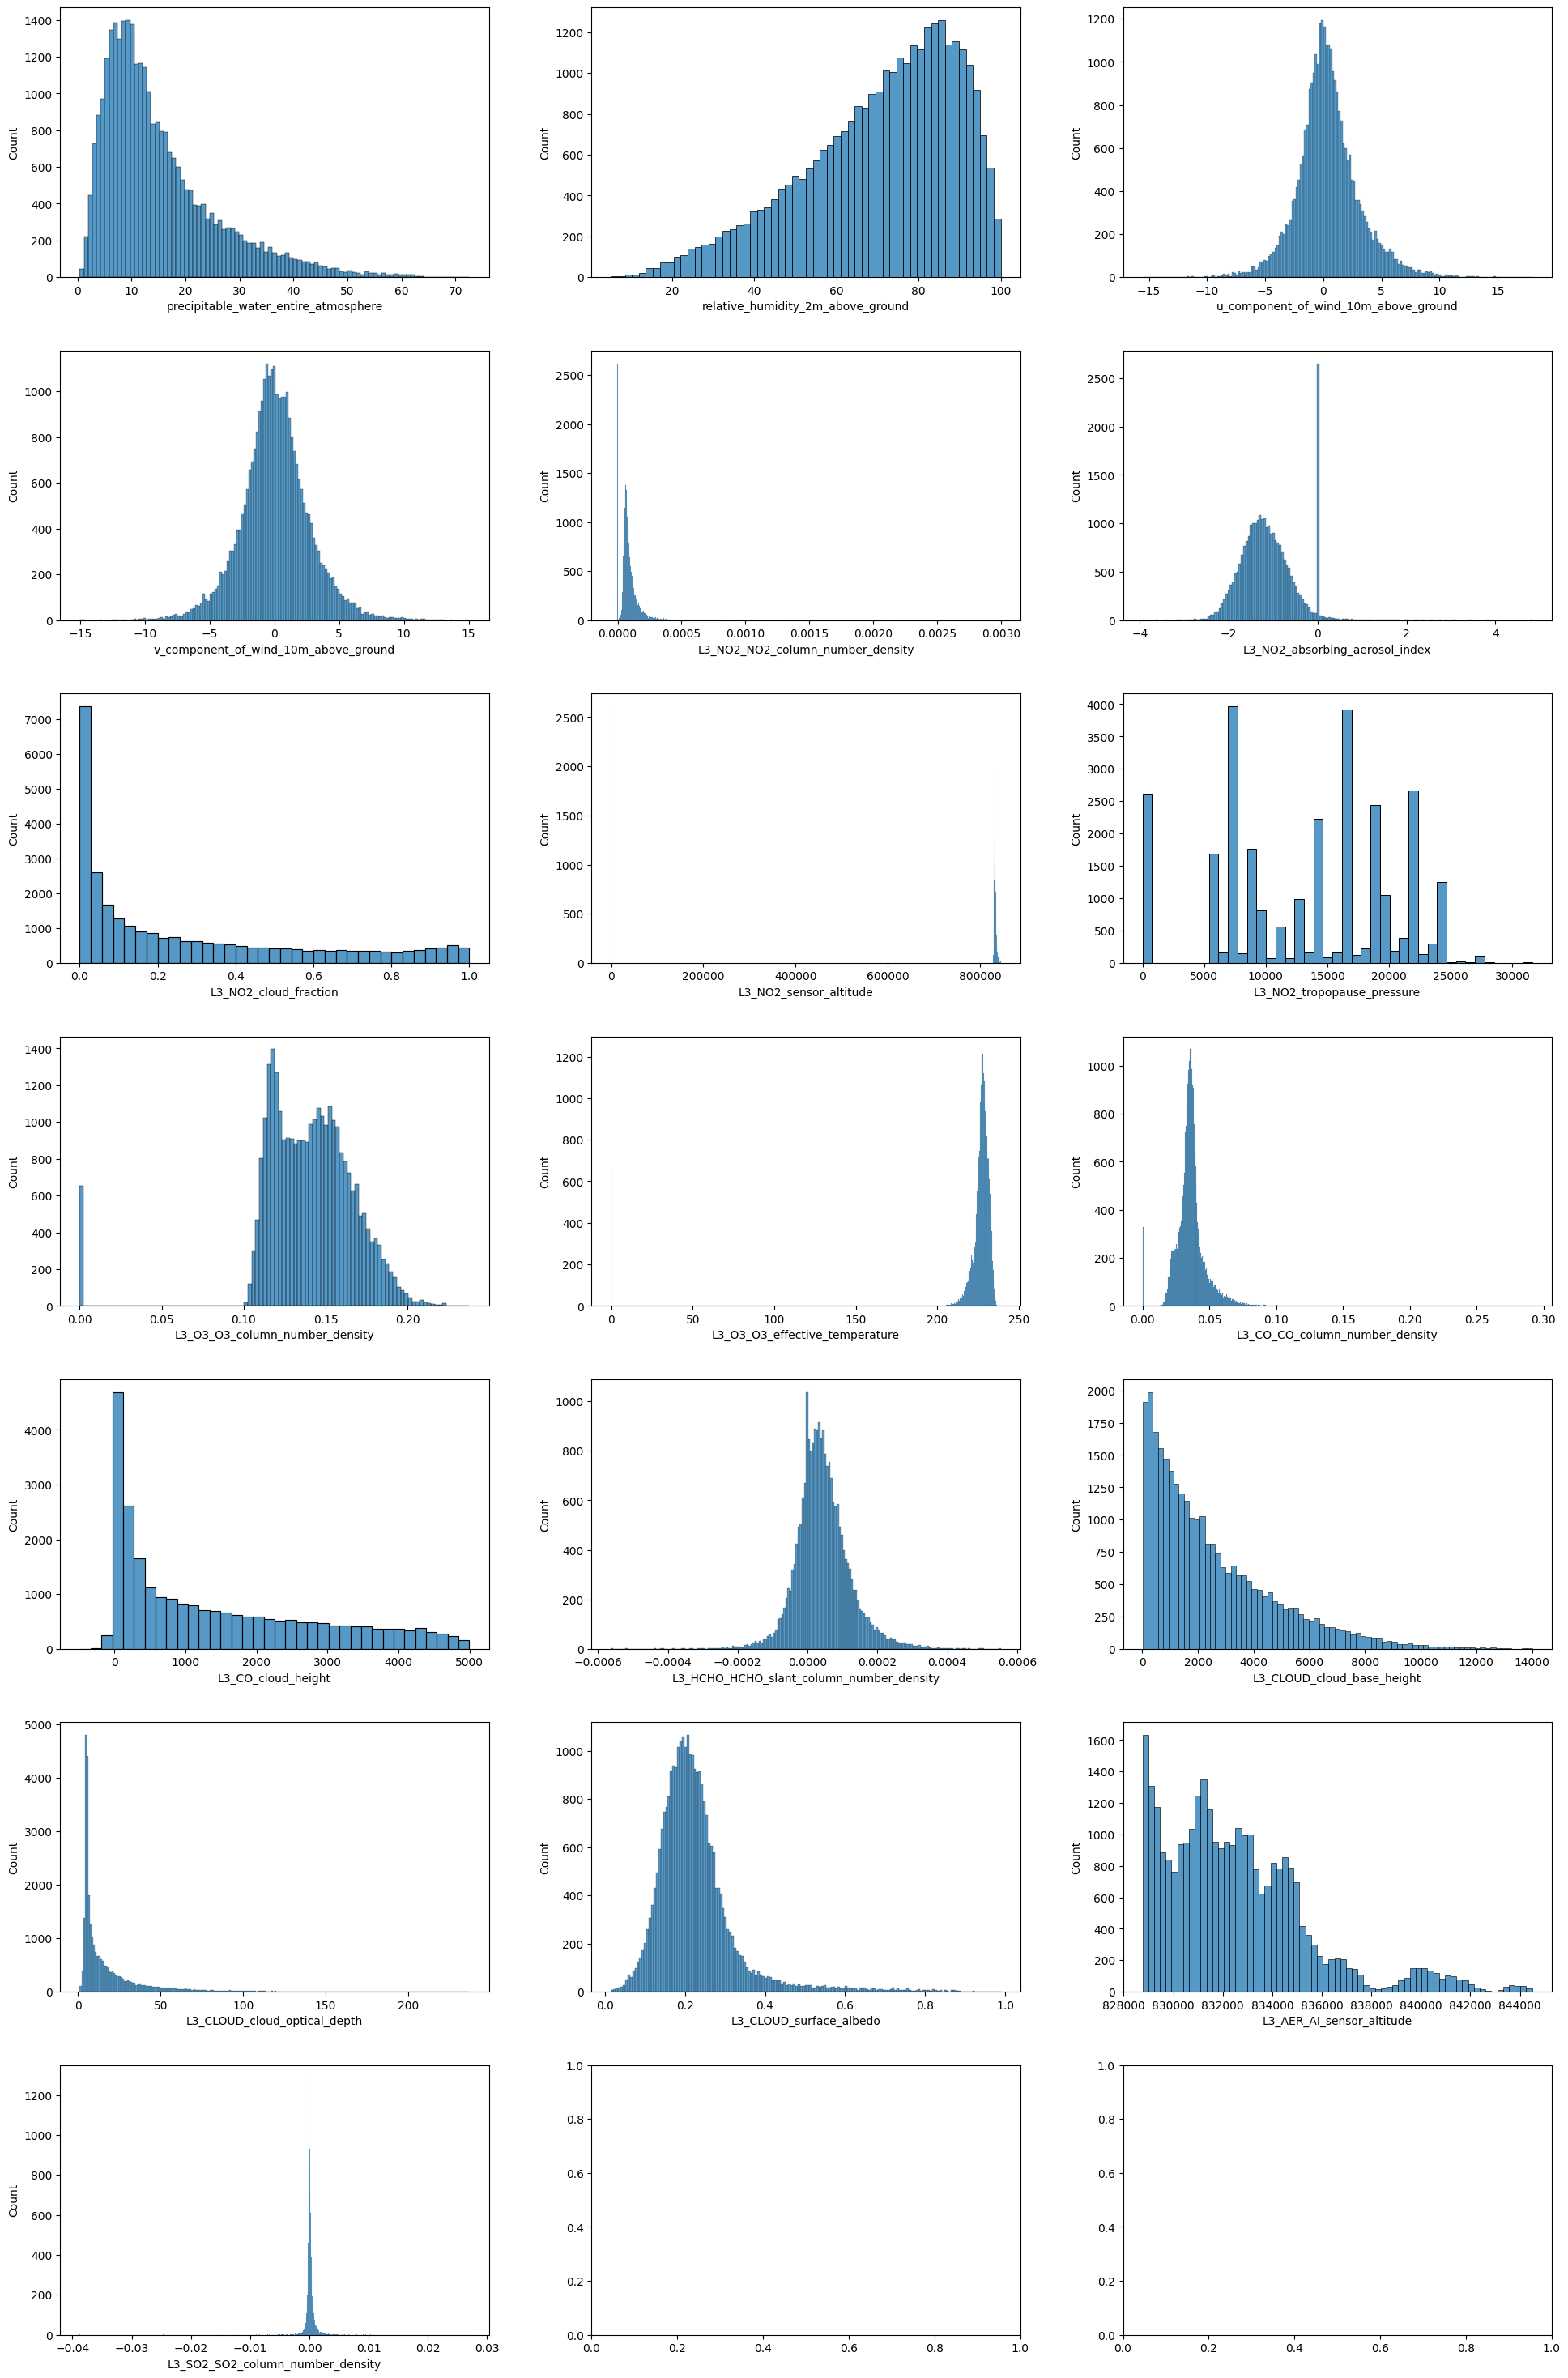

In [10]:
fix, axes = plt.subplots(7, 3, figsize=(20, 30))
axes = axes.flatten()

for ax, col in zip(axes, df.columns[8:]):
    sns.histplot(df, x=col, ax=ax)

plt.tight_layout(pad=3)

In [11]:
df.query("L3_CO_cloud_height <= 0").sort_values(by="L3_CO_cloud_height")
places = df.Place_ID.unique()
print(places)

['010Q650' '05EC30X' '0DPWHX8' '0GBXTHY' '0HYPV1N' '0I2XREH' '0KV6RJ1'
 '0MGEY68' '0O9R6AD' '0PP73FZ' '0RYZQUU' '0TFOCOS' '0TLH9UN' '11WPGRD'
 '168B2T2' '1GZGJPN' '1LC5FAK' '1PRBF5P' '1RYCZPT' '1SC5AWD' '1SKLTGJ'
 '1TE1HKJ' '1UEYEJQ' '1VN0K1S' '1WD100Y' '1X421B8' '1Y0S7TZ' '1YXF6T3'
 '1Z0FIHB' '1ZBVIMD' '215BUAP' '22D7H7I' '238N4KU' '28OSFYU' '2JZW8ZM'
 '2OR3E6X' '2S8UY1N' '2T41T7C' '2USU80I' '2WABRKJ' '35YN53B' '37VXILV'
 '3EJ33BJ' '3H1DEPM' '3HTVI1M' '3MXSVYJ' '3V177MC' '3WZQJU8' '4085G7L'
 '426FKUG' '431JQGO' '4EVR9T8' '4IVJPF2' '4WA4C0T' '4XP6UOX' '4ZMC9UQ'
 '50JFNAG' '57GIW0H' '5ETAG9S' '5I4TI4R' '5IOL334' '5IUK9TG' '5KE9R9R'
 '5M7ZX94' '5QYHA81' '5SXR1G0' '5YBO7PQ' '62HOUYZ' '693EWQR' '6CR3BYP'
 '6HXPCBH' '6J4AKCJ' '6KAHP8X' '6KHIOQ8' '6O56XQX' '6PWJJ6D' '6SJG8N2'
 '6TF1KNR' '6TLEFED' '6U70TX5' '73GXFXK' '7DRFQCK' '7LG0EUH' '7MO7ONT'
 '7NG0HSJ' '7YE6PEV' '89GCPDD' '8D88XH3' '8HLVCJG' '8ISJ2N4' '8OBB7UJ'
 '8YYQSD3' '8ZGB2UV' '8ZSYE9O' '90AJCJ1' '92A8XLV' '96GO3YA' '99IA3IO'
 '9BJU

In [12]:
for col in df.columns[8:]:
    print(f'''{col}
min, mean, max:           {df[col].min().round(3)}   {df[col].mean().round(3)}   {df[col].max().round(3)}
quantiles (25, 50, 75):   {df[col].quantile(0.25).round(3)}   {df[col].quantile(0.50).round(3)}   {df[col].quantile(0.75).round(3)}\n''')

precipitable_water_entire_atmosphere
min, mean, max:           0.42   15.302   72.6
quantiles (25, 50, 75):   7.667   12.2   19.9

relative_humidity_2m_above_ground
min, mean, max:           5.129   70.553   100.0
quantiles (25, 50, 75):   58.6   74.1   85.45

u_component_of_wind_10m_above_ground
min, mean, max:           -15.56   0.417   17.955
quantiles (25, 50, 75):   -1.098   0.222   1.773

v_component_of_wind_10m_above_ground
min, mean, max:           -15.024   0.088   15.056
quantiles (25, 50, 75):   -1.416   0.013   1.556

L3_NO2_NO2_column_number_density
min, mean, max:           -0.0   0.0   0.003
quantiles (25, 50, 75):   0.0   0.0   0.0

L3_NO2_absorbing_aerosol_index
min, mean, max:           -3.942   -1.094   4.825
quantiles (25, 50, 75):   -1.515   -1.168   -0.743

L3_NO2_cloud_fraction
min, mean, max:           0.0   0.278   1.0
quantiles (25, 50, 75):   0.026   0.149   0.47

L3_NO2_sensor_altitude
min, mean, max:           0.0   755880.302   844493.898
quantiles (25, 50

<Axes: xlabel='L3_CO_CO_column_number_density', ylabel='target'>

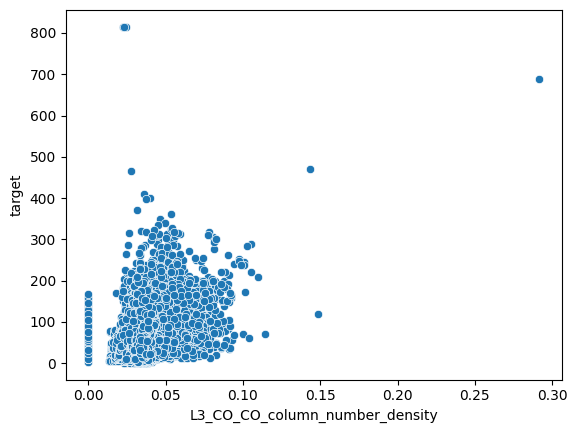

In [13]:
# baseline model based on strongest correlation to target: (?)
sns.scatterplot(df, x='L3_CO_CO_column_number_density', y='target')

In [17]:
cols = ["precipitable_water_entire_atmosphere", "relative_humidity_2m_above_ground", "u_component_of_wind_10m_above_ground", "v_component_of_wind_10m_above_ground"]
#add clouds?


def baselinemodel(df, target_col, feature_cols=None):

    if feature_cols == None:
        feature_cols = df.select_dtypes(include='number').columns.drop(target_col)

    X = df[feature_cols]
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Evaluation
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Baseline Linear Regression Results")
    print(f"Features: {list(feature_cols)}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²:   {r2:.3f}")

    return model, y_pred


model, preds = baselinemodel(df, target_col="target", feature_cols=cols)


Baseline Linear Regression Results
Features: ['precipitable_water_entire_atmosphere', 'relative_humidity_2m_above_ground', 'u_component_of_wind_10m_above_ground', 'v_component_of_wind_10m_above_ground']
RMSE: 46.255
R²:   0.028


In [ ]:


y = df.pop("target")
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED)  # ,stratify=y


In [19]:
df_train = pd.concat([X_train,y_train], axis=1)
df_test = pd.concat([X_test,y_test], axis=1)

df_train.shape, df_test.shape

((21389, 27), (9168, 27))

In [20]:
# drop target cols
# ["target" in col for col in num_cols.columns]
type(X_train), type(y_train)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [40]:



num_cols = X_train.select_dtypes("number").columns.tolist()
print(num_cols)
#X_train.select_dtypes("object").columns.tolist() #['Place_ID X Date', 'Date', 'Place_ID']

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', MinMaxScaler())
    ]), num_cols)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())  # Swap model here: Ridge(), Lasso(), RandomForestRegressor(), etc.
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

['target_min', 'target_max', 'target_variance', 'target_count', 'precipitable_water_entire_atmosphere', 'relative_humidity_2m_above_ground', 'u_component_of_wind_10m_above_ground', 'v_component_of_wind_10m_above_ground', 'L3_NO2_NO2_column_number_density', 'L3_NO2_absorbing_aerosol_index', 'L3_NO2_cloud_fraction', 'L3_NO2_sensor_altitude', 'L3_NO2_tropopause_pressure', 'L3_O3_O3_column_number_density', 'L3_O3_O3_effective_temperature', 'L3_CO_CO_column_number_density', 'L3_CO_cloud_height', 'L3_HCHO_HCHO_slant_column_number_density', 'L3_CLOUD_cloud_base_height', 'L3_CLOUD_cloud_optical_depth', 'L3_CLOUD_surface_albedo', 'L3_AER_AI_sensor_altitude', 'L3_SO2_SO2_column_number_density']


In [41]:
# Evaluation
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Baseline Linear Regression Results")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")

Baseline Linear Regression Results
RMSE: 19.796
R²:   0.811
